In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df=pd.read_csv("/Users/valent/Documents/Python/F1_scrape.csv")
austrian_sprint=pd.read_csv("/Users/valent/Documents/Python/sprint_scrape1.csv")
emilia_romagna_sprint=pd.read_csv("/Users/valent/Documents/Python/sprint_scrape2.csv")
sao_paulo_sprint=pd.read_csv("/Users/valent/Documents/Python/sprint_scrape3.csv")

In [2]:
#Drop columns
df=df.drop(columns=['No','Year','Car','Engine'])

In [3]:
#Sprint Set Up
austrian_sprint['event'] = 'Austrian GP'
emilia_romagna_sprint['event'] = 'Emilia Romagna GP'
sao_paulo_sprint['event'] = 'São Paulo GP'

columns=austrian_sprint.columns
for column in columns:
    new_column= column.lower()
    austrian_sprint.rename(columns={column: new_column}, inplace=True)
    emilia_romagna_sprint.rename(columns={column: new_column}, inplace=True)
    sao_paulo_sprint.rename(columns={column: new_column}, inplace=True)

sprint_pos = [1, 2, 3, 4, 5, 6, 7, 8]
sprint_point = sorted(list(range(1, 9)), reverse=True)
sprint = dict(zip(sprint_pos, sprint_point))

emilia_romagna_sprint['sprint_point'] = 0  # Initialize all values to 0
for index, row in emilia_romagna_sprint.iterrows():
    pos = row['pos']
    if pos == 'ret':
        emilia_romagna_sprint.at[index, "sprint_point"] = 0
    elif pos.isdigit():
        pos = int(pos)
        if pos in sprint.keys():
            emilia_romagna_sprint.at[index, "sprint_point"] = sprint[pos]

sao_paulo_sprint['sprint_point'] = 0  # Initialize all values to 0
for index, row in sao_paulo_sprint.iterrows():
    pos = row['pos']
    if pos == 'ret':
        sao_paulo_sprint.at[index, "sprint_point"] = 0
    elif pos.isdigit():
        pos = int(pos)
        if pos in sprint.keys():
            sao_paulo_sprint.at[index, "sprint_point"] = sprint[pos]

austrian_sprint['sprint_point'] = 0  # Initialize all values to 0
for index, row in austrian_sprint.iterrows():
    pos = row['pos']
    if pos == 'ret':
        austrian_sprint.at[index, "sprint_point"] = 0
    elif pos.isdigit():
        pos = int(pos)
        if pos in sprint.keys():
            austrian_sprint.at[index, "sprint_point"] = sprint[pos]    

In [4]:
#Column Set Up
columns=df.columns.tolist()
df.rename(columns={'Car No': 'car_no', 
                   'Qual pos': 'qual_pos', 
                   'Race pos': 'race_pos',
                   'Race time': 'race_time',
                   'Drivers\' champ pts': 'driver_point', 
                   'Constructors\' champ pts': 'constructors_point'}, inplace=True)
for column in columns:
    new_column= column.lower()
    df.rename(columns={column: new_column}, inplace=True)
    
df.columns

Index(['event', 'car_no', 'team', 'driver', 'qual_pos', 'race_pos',
       'race_time', 'driver_point', 'constructors_point'],
      dtype='object')

In [5]:
#Typo Set Up
df.loc[(df['team'] == 'Toro Rosso'), 'team'] = 'Alpha Tauri'
df.loc[(df['team'] == '-'), 'team'] = 'Alpine'
df.loc[(df['team'] == 'Mercedes-Benz'), 'team'] = 'Mercedes AMG'

In [6]:
#Albon got disqualified in Aus GP but got into the race again
df[(df["qual_pos"] == '-') & (df['driver'] == 'Alexander Albon')]
df.loc[(df["qual_pos"] == '-') & (df['driver'] == 'Alexander Albon') & (df['event'] == 'Australian GP'), 'qual_pos'] = '20'

In [7]:
#Drivers Set Up
drivers=df.driver.unique().tolist()
main_drivers=['Max Verstappen', 'Daniel Ricciardo', 'Lando Norris', 'Nicholas Latifi', 'Pierre Gasly', 'Sergio Pérez',\
              'Fernando Alonso', 'Charles Leclerc', 'Lance Stroll', 'Kevin Magnussen', 'Yuki Tsunoda', 'Alexander Albon'\
              , 'Guanyu Zhou', 'Nico Hülkenberg', 'Esteban Ocon', 'Lewis Hamilton', 'Mick Schumacher', 'Carlos Sainz', \
              'George Russell', 'Valtteri Bottas', 'Sebastian Vettel','Nyck de Vries']
df= df[df['driver'].isin(main_drivers)]

In [8]:
# Except Albon in Australian GP, all driver with '-' qualifying position did not participate even once.
df=df[df.qual_pos!='-']

In [9]:
#Sprint Merge
df = df.merge(austrian_sprint[['event', 'driver','pos', 'sprint_point']], 
                     on=['event', 'driver'],  
                     how='left')
df = df.merge(emilia_romagna_sprint[['event', 'driver','pos', 'sprint_point']], 
                     on=['event', 'driver'],  
                     how='left')
df = df.merge(sao_paulo_sprint[['event', 'driver','pos', 'sprint_point']], 
                     on=['event', 'driver'],  
                     how='left')

In [10]:
# Clean up race_pos column
for index, row in df.iterrows():
    race_pos = row['race_pos']
    
    if 'ret' in race_pos:
        df.at[index, 'race_pos'] = 'DNF'
    elif 'dns' in race_pos:
        df.at[index, 'race_pos'] = 'DNS'
    else:
        df.at[index, 'race_pos'] = 'P{}'.format(row['race_pos'])

In [11]:
# Update sprint_pos column
df["sprint_pos"] = df['pos_x'].fillna(df['pos_y']).fillna(df['pos'])

# Update sprint_point column
df["sprint_points"] = df['sprint_point_x'].fillna(df['sprint_point_y']).fillna(df['sprint_point'])

# Drop intermediate columns (if needed)
df.drop(['pos_x', 'pos_y', 'pos', 'sprint_point_x', 'sprint_point_y','sprint_point'], axis=1, inplace=True)


In [12]:
#Not all main drivers participate in all of the grand prix
count_pivot = df.pivot(index=['driver', 'team', 'car_no'], columns='event', values='race_pos')
count_pivot = count_pivot.fillna("DP")

# Reset the index to have 'driver', 'team', and 'car_no' as columns
count_pivot = count_pivot.reset_index()

# Melt the DataFrame to switch columns into rows
melted_df = pd.melt(count_pivot, id_vars=['driver', 'team', 'car_no'], var_name='event', value_name='race_pos')

df = df.merge(melted_df,how='outer') 

df[['qual_pos', 'race_pos', 'sprint_pos']] = df[['qual_pos', 'race_pos', 'sprint_pos']].fillna("DP")
df[['sprint_points', 'sprint_pos', 'driver_point', 'constructors_point',
   'race_time']]=df[['sprint_points', 'sprint_pos', 'driver_point', 'constructors_point','race_time']].fillna("0")
df[df['driver_point'].isnull()]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 484 entries, 0 to 483
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   event               484 non-null    object
 1   car_no              484 non-null    int64 
 2   team                484 non-null    object
 3   driver              484 non-null    object
 4   qual_pos            484 non-null    object
 5   race_pos            484 non-null    object
 6   race_time           484 non-null    object
 7   driver_point        484 non-null    object
 8   constructors_point  484 non-null    object
 9   sprint_pos          484 non-null    object
 10  sprint_points       484 non-null    object
dtypes: int64(1), object(10)
memory usage: 45.4+ KB


In [13]:
# Clean up qual_pos column

for index, row in df.iterrows():
    qual_pos = str(row['qual_pos'])  # Convert to string
    if qual_pos.isdigit():
        df.at[index, 'qual_pos'] = 'P{}'.format(qual_pos)
    else:
        df.at[index, 'qual_pos'] = row['qual_pos']

In [14]:
# GP Position
df['GP_position'] = ''
for index, row in df.iterrows():
    race_pos = row['race_pos']
    
    if race_pos== 'P1':
        df.at[index, 'GP_position'] = 'Win'
    elif race_pos== 'P2':
        df.at[index, 'GP_position'] = 'Second Place'
    elif race_pos== 'P3':
        df.at[index, 'GP_position'] = 'Third Place'
    elif race_pos in ['P4','P5','P6','P7','P8','P9','P10']:
        df.at[index, 'GP_position'] = 'Point Finish' 
    elif race_pos== 'DNF':
        df.at[index, 'GP_position'] = 'DNF'
    elif race_pos== 'DNS':
        df.at[index, 'GP_position'] = 'DNS' 
    elif race_pos== 'DP':
        df.at[index, 'GP_position'] = 'DP' 
    else:
        df.at[index, 'GP_position'] = 'Out of Point'

In [15]:
#Pole position
df['pole'] = False

# Set 'pole' to True where 'qual_pos' is 'P1'
df.loc[df['qual_pos'] == 'P1', 'pole'] = True
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 484 entries, 0 to 483
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   event               484 non-null    object
 1   car_no              484 non-null    int64 
 2   team                484 non-null    object
 3   driver              484 non-null    object
 4   qual_pos            484 non-null    object
 5   race_pos            484 non-null    object
 6   race_time           484 non-null    object
 7   driver_point        484 non-null    object
 8   constructors_point  484 non-null    object
 9   sprint_pos          484 non-null    object
 10  sprint_points       484 non-null    object
 11  GP_position         484 non-null    object
 12  pole                484 non-null    bool  
dtypes: bool(1), int64(1), object(11)
memory usage: 65.8+ KB


In [16]:
df['driver_point'] = df['driver_point'].str.replace('-', '0')
df["constructors_point"] = df["constructors_point"].str.replace('-', '0')
df["driver_point"]=df["driver_point"].astype(int)
df["constructors_point"]=df["constructors_point"].astype(int)
df["sprint_points"]=df["sprint_points"].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 484 entries, 0 to 483
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   event               484 non-null    object
 1   car_no              484 non-null    int64 
 2   team                484 non-null    object
 3   driver              484 non-null    object
 4   qual_pos            484 non-null    object
 5   race_pos            484 non-null    object
 6   race_time           484 non-null    object
 7   driver_point        484 non-null    int64 
 8   constructors_point  484 non-null    int64 
 9   sprint_pos          484 non-null    object
 10  sprint_points       484 non-null    int64 
 11  GP_position         484 non-null    object
 12  pole                484 non-null    bool  
dtypes: bool(1), int64(4), object(8)
memory usage: 65.8+ KB


In [17]:
df["total_point"] = df["sprint_points"] + df["constructors_point"]


In [18]:
#Check driver points
# List of unique drivers
drivers = df['driver'].unique()

# Iterate through each driver
for driver in drivers:
    # Filter the DataFrame for the current driver
    driver_data = df[df['driver'] == driver]
    
    # Print the desired columns for the driver
    print(driver_data[['driver','event', 'race_pos','constructors_point', 'sprint_points', 'total_point']])


             driver              event race_pos  constructors_point  \
0    Max Verstappen         Bahrain GP      P19                   0   
20   Max Verstappen   Saudi Arabian GP       P1                  25   
40   Max Verstappen      Australian GP      DNF                   0   
60   Max Verstappen  Emilia Romagna GP       P1                  26   
80   Max Verstappen           Miami GP       P1                  26   
100  Max Verstappen         Spanish GP       P1                  25   
120  Max Verstappen          Monaco GP       P3                  15   
140  Max Verstappen      Azerbaijan GP       P1                  25   
160  Max Verstappen        Canadian GP       P1                  25   
180  Max Verstappen         British GP       P7                   6   
200  Max Verstappen        Austrian GP       P2                  19   
220  Max Verstappen          French GP       P1                  25   
240  Max Verstappen       Hungarian GP       P1                  25   
260  M

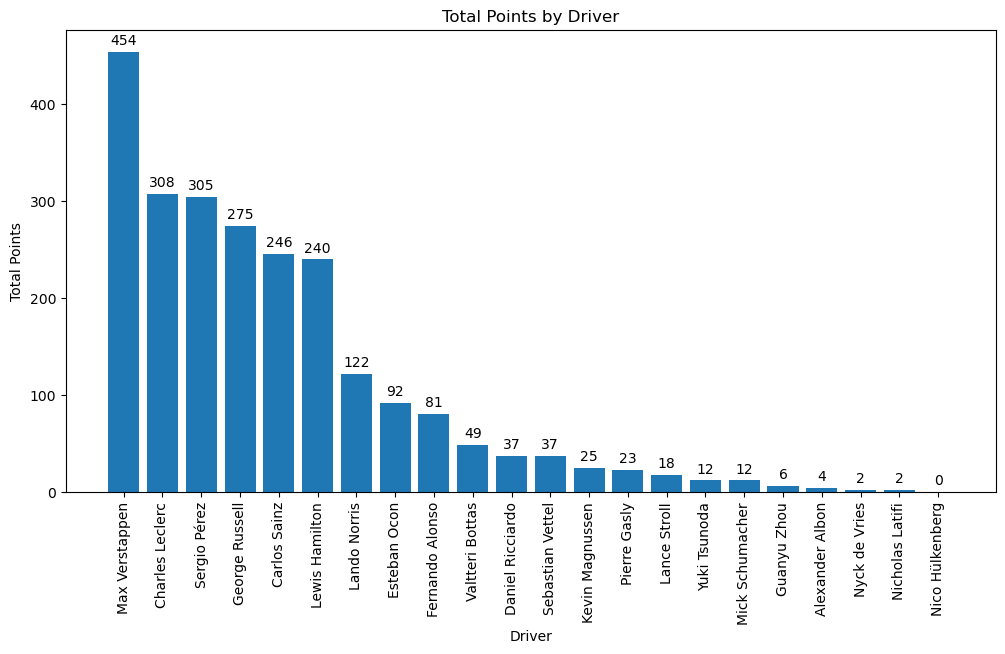

In [19]:
# Group the DataFrame by driver and calculate the sum of total points for each driver
driver_totals = df.groupby('driver')['total_point'].sum().reset_index()

# Sort the drivers by total points in descending order
driver_totals = driver_totals.sort_values(by='total_point', ascending=False)

# Create a bar chart
plt.figure(figsize=(12, 6))
bars = plt.bar(driver_totals['driver'], driver_totals['total_point'])
plt.xlabel('Driver')
plt.ylabel('Total Points')
plt.title('Total Points by Driver')
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility

# Add annotations with total points on top of the bars
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:.0f}', 
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),  # 3 points vertical offset
                 textcoords="offset points",
                 ha='center', va='bottom')
    


In [20]:
result = df.groupby(["race_pos", "constructors_point"]).size().reset_index(name="count")

# Sort the result by "race_pos"
sorted_result = result.sort_values(by="constructors_point", ascending=False)
print(sorted_result)

   race_pos  constructors_point  count
4        P1                  26      7
3        P1                  25     15
16       P2                  19      6
15       P2                  18     16
19       P3                  16      1
18       P3                  15     21
21       P4                  13      1
20       P4                  12     21
23       P5                  11      2
22       P5                  10     20
25       P6                   9      3
24       P6                   8     19
26       P7                   6     22
27       P8                   4     22
28       P9                   2     22
5       P10                   1     22
17      P20                   0      1
0       DNF                   0     62
1       DNS                   0      2
13      P18                   0      9
12      P17                   0     16
11      P16                   0     20
10      P15                   0     19
9       P14                   0     22
8       P13              

In [21]:
df["fastest_lap"] = False  # Initialize the "fastest_lap" column to False

point = {
    'P1': 25, 'P2': 18, 'P3': 15, 'P4': 12, 'P5': 10, 'P6': 8, 'P7': 6, 'P8': 4, 'P9': 2, 'P10': 1,
    'P11': 0, 'P12': 0, 'P13': 0, 'P14': 0, 'P15': 0, 'P16': 0, 'P17': 0, 'P18': 0, 'P19': 0, 'P20': 0,
    'DNS': 0, 'DNF': 0,'DP':0
}

for index, row in df.iterrows():
    race_pos = row["race_pos"]
    constructors_point = row["constructors_point"]

    if race_pos in point.keys() and constructors_point != point[race_pos]:
        df.at[index, "fastest_lap"] = True
    else:
        df.at[index, "fastest_lap"] = False


In [22]:
df['index']=range(len(df))
df.to_csv(r'/Users/valent/Documents/Python/F1_Clean.csv',index= False)
df.head()

,event,car_no,team,driver,qual_pos,race_pos,race_time,driver_point,constructors_point,sprint_pos,sprint_points,GP_position,pole,total_point,fastest_lap,index
0,Bahrain GP,1,Red Bull,Max Verstappen,P2,P19,1:33:17.696,0,0,DP,0,Out of Point,False,0,False,0
1,Bahrain GP,3,McLaren,Daniel Ricciardo,P18,P14,1:38:28.559,0,0,DP,0,Out of Point,False,0,False,1
2,Bahrain GP,4,McLaren,Lando Norris,P13,P15,1:38:29.919,0,0,DP,0,Out of Point,False,0,False,2
3,Bahrain GP,6,Williams,Nicholas Latifi,P20,P16,1:38:35.379,0,0,DP,0,Out of Point,False,0,False,3
4,Bahrain GP,10,Alpha Tauri,Pierre Gasly,P10,DNF,1:13:54.365,0,0,DP,0,DNF,False,0,False,4
